## Not important for plotting

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Mounted at /content/gdrive


In [3]:
!cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/carbon_levels.py /content
!cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/past.py /content
!cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/params.py /content
!cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/future.py /content


In [4]:
import carbon_levels
import past
import params
from future import scenario

### Parameters  and conversion factors


In [5]:
ka, kd, delta_d, kH, AM, OM, M_upper, delta_a, K_1, K_2, Alk = params.ocean_params
mumix, mudeep, lambdaHat, gamma = params.temp_params
tao, beta,Cpf_moles, propCH4, propPassive, pf_init_T = params.permafrost_params
fds, fld, fls, flv, fnd, fns, fnv, frd, frs, fvd, fvs, beta_biota, q10, biota_init_T, npp_0 = params.biota_params

In [6]:
ppmtoMol = 1.77e+14 #mult by this for CO2 PPM -> Moles
molCO2toGT =  4.4e-14 #mult by this for moles CO2 -> GTC
ppmtoGT = 7.788 #mult by this for ppm to GTC
molCtoGT = 12/1e15

### Data



Getting the data in ppm for $CO_2$

In [7]:
file_loc = r"/content/gdrive/My Drive/ColabHannah/Data/WG1AR5_AIISM_Datafiles.xlsx"

# ppm_Data  = pd.read_excel(file_loc, 6, header = 7, index_col=0, usecols="A:D", skiprows=[8],skipfooter=40) #ppm
ppm_data_source  = pd.read_excel(file_loc, 6, header = 7, usecols="A:D", skiprows=[8],skipfooter=40) #ppm  NOte I didn't do an index col so I could get an array of years. 


ppm_data_source.columns = ['Year', 'CO2', 'CH4', 'N2O']

In [8]:
#linear interpolation

ppm_data = pd.DataFrame(columns=['Year', 'CO2', 'CH4', 'N2O'])

for k in ppm_data.columns:
    ppm_data[k] =  np.interp(np.arange(1750,2011), ppm_data_source.Year, ppm_data_source[k])

ppm_data = ppm_data.astype({'Year':'int'})




Getting the data in terms of ERF

In [9]:
# ERF_data  = pd.read_excel(file_loc, 8, header = 7, usecols="A:M", skipfooter=5) #ppm  NOte I didn't do an index col so I could get an array of years. 


 Carbon data

In [10]:

#global K_H K_1 K_2 delta_d delta_a AM Alk k_a k_d E_course
fname = r'/content/gdrive/My Drive/ColabHannah/Data/Global_Carbon_Budget_2021v1.0.xlsx'

carbon_df = pd.read_excel(fname, sheet_name = "Historical Budget", header = 16,
                                 names = ['Year', 'Fossil', 'LUC', 'Atm_Growth', 'Ocean_Sink', 'Land_Sink', 'Cement_Carb_Sink', 'Imbalance']);

#Dr Eikenberry's linear interp
#Do a linear interpolation from 0.2 to value at 1850 for LUC:
carbon_df.LUC.iloc[0:99] = np.interp(carbon_df.Year[0:99], [1751, 1849], [0.2, carbon_df.LUC[99]])

<ipython-input-10-df1ca0fc931d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_df.LUC.iloc[0:99] = np.interp(carbon_df.Year[0:99], [1751, 1849], [0.2, carbon_df.LUC[99]])


## Past Modeling

In [11]:
init_ppm = params.ppmCO2_1750 

initC = carbon_levels.get_C_init(init_ppm)
# new_QA = 1000 * ppmtoMol
# start_ocean = np.array([new_QA, 725 * ppmtoMol, 36262 * ppmtoMol])

# print(initC * 12/ 1e15)

temp = np.array([0,0])

inits = np.concatenate((temp,initC), axis=None)

t_span=[1750,2010]
# ERF_data.head()


sol_2010_imposed, temp_track = past.solve_past(t_span, inits, ppm_data, carbon_df, True)

sol_2010, temp_track = past.solve_past(t_span, inits, ppm_data, carbon_df, False)




/content/past.py:95: RuntimeWarning: divide by zero encountered in log
  result = (npp_0 / molCtoGT) * (1 + beta_biota * ( np.log ( carbon /  params.ppmCO2_1750 )))


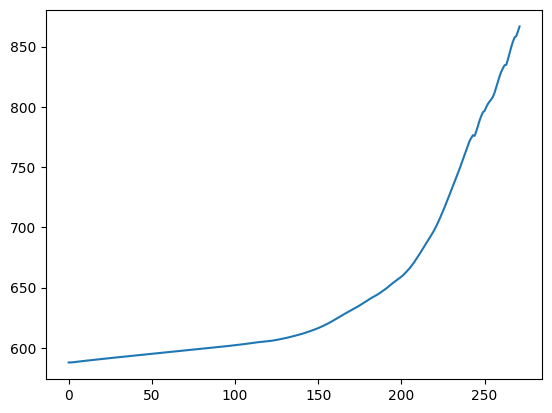

In [12]:
plt.plot(sol_2010.y[2,:] * 12 / 1e15)

In [13]:
# #state 2010
# index_max = len(sol_2010.t) - 1
# state_2010 = sol_2010.y[:,index_max] #QA not right here!!!!!

# ppm_2010 = ppm_data.loc[ppm_data["Year"] == 2010].values[0][1]

# molesQA = ppm_2010 / 1e6 * AM
# state_2010[2] = molesQA

# state_2010 * 12 / 1e15
# # state_2010

In [14]:
ppmarray = ppm_data["CO2"]

t = np.linspace(1760, 2020, 261)

In [15]:
#actaul temps


fname = r'/content/gdrive/My Drive/ColabHannah/Data/HadCRUT_Temp.csv'
temp_df = pd.read_csv(fname, header = 0 , nrows = 161)
temp_df.columns = ['Year', 'Anomaly', 'Lower confidence', 'Upper confidence', 'Anomaly2']
temp_df['Adjusted'] = temp_df.Anomaly2 + .3565

temp_df

,Year,Anomaly,Lower confidence,Upper confidence,Anomaly2,Adjusted
0,1850,-0.417659,-0.589203,-0.246115,-0.061159,0.295341
1,1851,-0.233350,-0.411868,-0.054832,0.123150,0.479650
2,1852,-0.229399,-0.409382,-0.049416,0.127101,0.483601
3,1853,-0.270354,-0.430009,-0.110700,0.086146,0.442646
4,1854,-0.291630,-0.432824,-0.150436,0.064870,0.421370
...,...,...,...,...,...,...
156,2006,0.572553,0.541973,0.603132,0.929053,1.285553
157,2007,0.591701,0.561353,0.622050,0.948201,1.304701
158,2008,0.465650,0.432657,0.498642,0.822150,1.178650
159,2009,0.596782,0.565256,0.628308,0.953282,1.309782


#### Figures

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

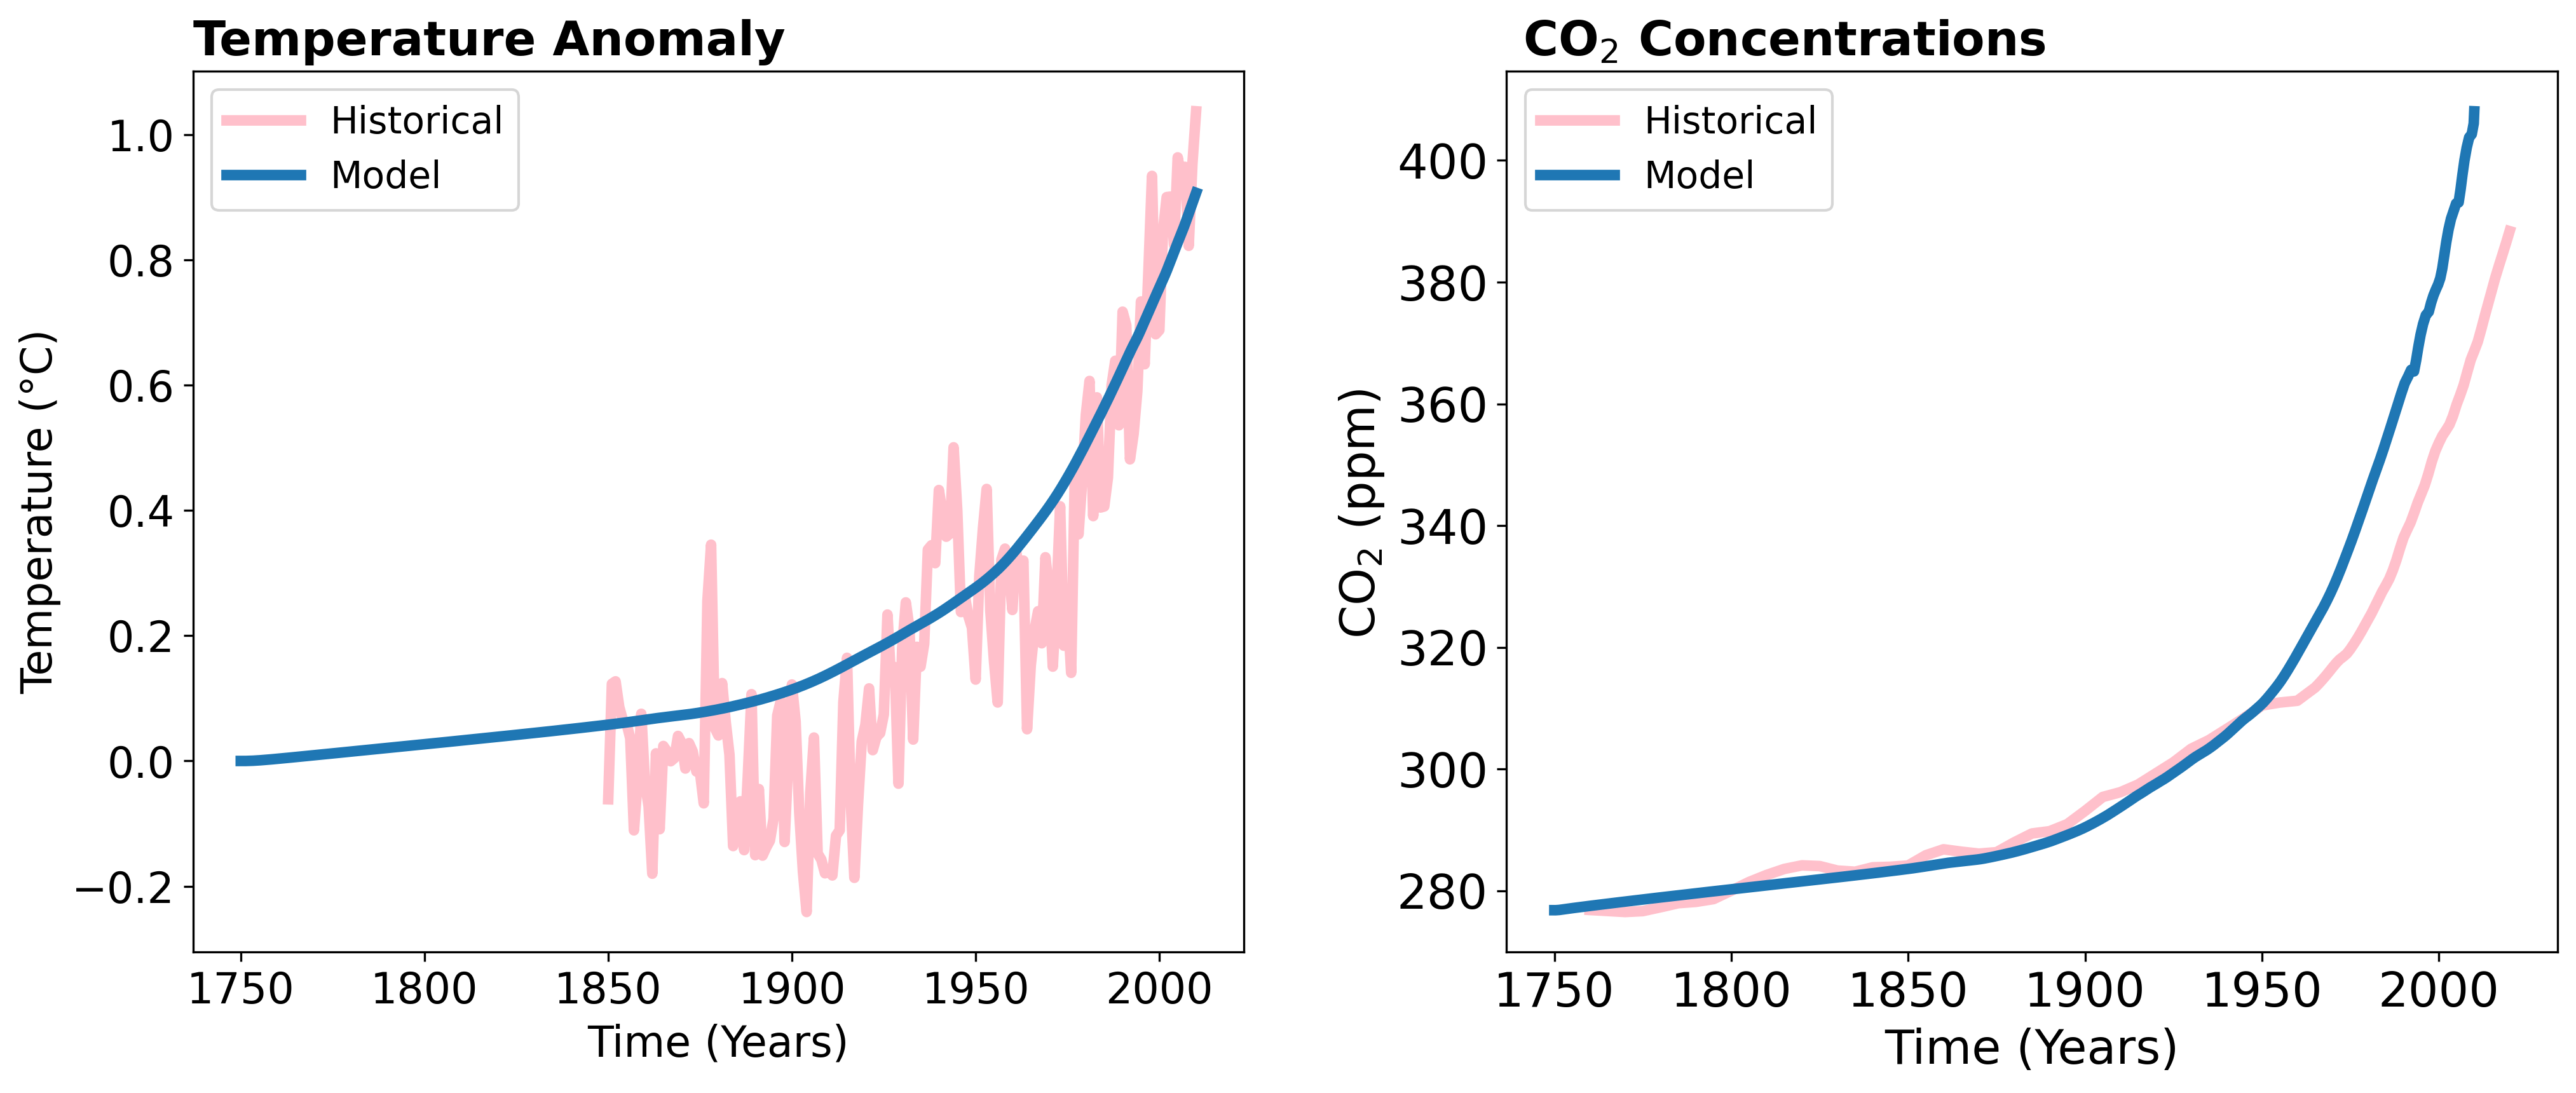

In [21]:
fig, ax1 = plt.subplots(1, 2, figsize=(16,6), dpi=300)
fs =18
lw = 4
coord = 0
ax1[coord].plot(temp_df.Year, temp_df.Anomaly2, linewidth=lw, color ='pink', label='Historical')
ax1[coord].plot(sol_2010.t, sol_2010.y[0,:], linewidth=lw, label='Model')
# ax1[coord].plot(sol_2010_imposed.t, sol_2010_imposed.y[0,:], linewidth=2, label='RF from CO$_2$ ppm')
ax1[coord].legend(fontsize = fs-4)
ax1[coord].set_title("Temperature Anomaly", loc = "left", fontsize = fs, fontweight = "bold")
ax1[coord].set_xlabel("Time (Years)", fontsize = fs )
ax1[coord].set_ylabel("Temperature (°C)", fontsize = fs)

for item in ([ax1[coord].title, ax1[coord].xaxis.label, ax1[coord].yaxis.label] +  ax1[coord].get_xticklabels() + ax1[coord].get_yticklabels()):
    item.set_fontsize(fs-2)


coord = 1
ax1[coord].plot(t, ppmarray, linewidth=lw, color = "pink", label='Historical')
ax1[coord].plot(sol_2010.t, sol_2010.y[2,:] / AM * 1e6, linewidth=lw, label='Model')
ax1[coord].legend(fontsize = fs-4)
ax1[coord].set_title(" CO$_2$ Concentrations", loc = "left", fontsize = fs , fontweight = "bold")
ax1[coord].set_xlabel("Time (Years)")
ax1[coord].set_ylabel("CO$_2$ (ppm) ")

for item in ([ax1[coord].title, ax1[coord].xaxis.label, ax1[coord].yaxis.label] +  ax1[coord].get_xticklabels() + ax1[coord].get_yticklabels()):
    item.set_fontsize(fs)


plt.subplots_adjust(wspace=0.25, hspace=0.25) 



fname = "past_poster.png"
plt.savefig(fname, dpi=300, facecolor="white", bbox_inches='tight', pad_inches=0.05)
files.download(fname)


In [17]:

# fig, ax = plt.subplots(1, 1, figsize = (10,5), dpi =300 )
# fs = 12
# rate_per = []
# for x in rate:
#   rate_per.append((1-x) * 100)

# plt.subplots_adjust(wspace=0.25, hspace=0.25) 
# lw =3
# ax.plot(rate_per, temp275,linewidth=lw, label = "275 Mt CH4")
# ax.plot(rate_per, temp250, linewidth=lw, label = "250 Mt CH4")
# ax.plot(rate_per, temp225, linewidth=lw, label = "225 Mt CH4")
# ax.plot(rate_per, temp200, linewidth=lw, label = "200 Mt CH4")
# ax.plot(rate_per, temp175, linewidth=lw, label = "175 Mt CH4")
# ax.plot(rate_per, temp150, linewidth=lw, label = "150 Mt CH4")
# ax.plot(rate_per, temp125, linewidth=lw, label = "125 Mt CH4")
# ax.legend(loc = 'upper right', title="Floor")
# ax.set_title("Temp Response to Rate of Reducion (RCP 4.5 with Permafrost)", fontsize = fs+2)
# ax.tick_params(axis='both', labelsize=fs-2)
# ax.set_xlabel("Rate of Reduction (%)", fontsize = fs)
# ax.set_ylabel(" Temperature at Year 2300 (°C)", fontsize = fs)



# fname = "rate_temp.png"
# plt.savefig(fname, dpi=300, facecolor="white", bbox_inches='tight', pad_inches=0.05)
# files.download(fname)